# Bike Sharing Demand Prediction for BoomBikes
#### Context of Problem:
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands

#### Steps:
* [Data Understanding](#data_understanding)
    * [Loading the Data](#data_loading)
    * [Remove unuseful columns](#unseful_columns)
* [Data Cleaning and Manipulation](#data_wrangling)
    * [Create Dummy Variables](#dummy_variables)
    * [Deriving New Columns](#derive_columns)
    * [Remove Outliers](#remove_outliers)
    
* [Data Visualization and Analysis](#data_analysis)
    * [Univariate Analysis](#univarient_analysis)
    * [Segmented Univariate Analysis](#segmented_univarient)
    * [Bivariate Analysis](#Bivariate)
* [Model Development](#model_devlopment)
    * [Train-Test Split](#data_splitting)

# Step 1: Data Understanding <a class="anchor" id="data_understanding"></a>

In the Data Understanding step, we thoroughly examined the dataset to identify and report all data quality issues.<br>
Additionally, we ensured that the meanings of all variables were accurately interpreted

##### Loading Libraries and Data <a class="anchor" id="data_loading"></a>


In [58]:
import pandas as pd
import numpy as np
import os


#importing Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px #plotting
from pypalettes import get_hex



#importing Libraries for model building.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Warnings library will be used to ignore some warnings
import warnings #warning
warnings.filterwarnings('ignore')

In [22]:
# Loading the data
df = pd.read_csv("data/day.csv")

In [23]:
# Print the data
df.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [24]:
# Check the basic info about the data
print('Shape of df:',df.shape)

# No.of missing values
print('No.of missing values:',df.isnull().sum().sum())

# No.of duplicates
print('No.of duplicates:',df.duplicated().sum())

# Check the column names and there dtypes.
print("Datatypes of all the columns:\n",df.columns.to_series().groupby(df.dtypes).groups)

Shape of df: (730, 16)
No.of missing values: 0
No.of duplicates: 0
Datatypes of all the columns:
 {int64: ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'casual', 'registered', 'cnt'], float64: ['temp', 'atemp', 'hum', 'windspeed'], object: ['dteday']}


* There are 16 columns and 730 rows in the dataset.
* Some columns are categorical in nature (like mnth, season, weekday and weathersit), however, their datatype is int64 which needs to be        handled later during the data cleaning process.
* There are definitely some columns (like instant, dteday, casual, registered) that can be dropped as they are irrelevant/redundant to our analysis and model building.
* There are no null values in the dataset.
* There are no duplicates in the dataset.


#### Removal of columns that are not useful for analysis. <a class="anchor" id="unseful_columns"></a>
1. **instant**: It is just a sequence number of rows
2. **dteday**: It is not required since columns for year & month already exists
3. **casual**: This variable cannot be predicted.
4. **registered**: This variable cannot be predicted.

In [25]:
df.drop(['casual', 'dteday', 'instant', 'registered'], axis = 1, inplace = True)
df.shape

(730, 12)

# Step2: Data Cleaning and Manipulation <a class="anchor" id="data_wrangling"></a>

Data quality issues, such as missing values, outliers, and redundancies, are effectively addressed using appropriate methods.

When necessary, the data is converted into a suitable and convenient format for analysis.

String and date manipulations are performed accurately as needed.


#### Dummy Variables<a class="anchor" id="dummy_variables"></a>
1. **season**: Converting season into a dummy variable as per data dictionary(1:spring, 2:summer, 3:fall, 4:winter)
2. **weathersit**:Converting weathersit into a dummy variable as per data dictionary
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (weather_mist_cloud)
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds(weather_light_snow_rain)
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog(weather_heavy_snow_thunderstorm)

In [31]:
season_type = pd.get_dummies(df['season'], drop_first = True,dtype=int)
season_type.rename(columns={2:"season_summer", 3:"season_fall", 4:"season_winter"},inplace=True)
season_type.head()


,season_summer,season_fall,season_winter
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [33]:
df['weathersit'].value_counts()

weathersit
1    463
2    246
3     21
Name: count, dtype: int64

> Note: The 'weathersit' column in the provided dataset contains only three categories, even though the data dictionary lists four

In [36]:
weather_type = pd.get_dummies(df['weathersit'], drop_first = True,dtype=int)
weather_type.rename(columns={2:"weather_mist_cloud", 3:"weather_light_snow_rain"},inplace=True)
weather_type.head()


,weather_mist_cloud,weather_light_snow_rain
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


In [40]:
#Concatenating new dummy variables to the main dataframe

df = pd.concat([df,season_type,weather_type],axis=1)
#Dropping columns season & weathersit since we have already created dummies for them
df.drop(columns=["season", "weathersit"],axis=1,inplace =True)

#Analysing dataframe after dropping columns
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   yr                       730 non-null    int64  
 1   mnth                     730 non-null    int64  
 2   holiday                  730 non-null    int64  
 3   weekday                  730 non-null    int64  
 4   workingday               730 non-null    int64  
 5   temp                     730 non-null    float64
 6   atemp                    730 non-null    float64
 7   hum                      730 non-null    float64
 8   windspeed                730 non-null    float64
 9   cnt                      730 non-null    int64  
 10  season_summer            730 non-null    int64  
 11  season_fall              730 non-null    int64  
 12  season_winter            730 non-null    int64  
 13  weather_mist_cloud       730 non-null    int64  
 14  weather_light_snow_rain  7

#### Deriving New Columns <a class="anchor" id="derive_columns"></a>

1. Creating year_quarter derived columns from month columns.
2. Convert weekday column to represent if its a weekend or just a weekday. i.e if 1 <= weekday <= 5 then its a weekday else its a weekend
> Note that last quarter has not been created since we need only 3 columns to define the four quarters.
> Similarly a weekend column is not add as a weekday or a weekend can be represented with 1 column


In [43]:
df["Quarter_JanFebMar"] = df["mnth"].apply(lambda x: 1 if x<=3 else 0)
df["Quarter_AprMayJun"] = df["mnth"].apply(lambda x: 1 if 4<=x<=6 else 0)
df["Quarter_JulAugSep"] = df["mnth"].apply(lambda x: 1 if 7<=x<=9 else 0)

#Dropping column mnth since we have already created dummies.
df.drop(columns=["mnth"],axis=1,inplace =True)
df["weekend"] = df["weekday"].apply(lambda x: 0 if 1<=x<=5 else 1)
df.drop(columns=["weekday"],axis=1,inplace =True)
df.drop(columns=["workingday"],axis=1,inplace =True)
df.head()



,yr,holiday,temp,atemp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weather_mist_cloud,weather_light_snow_rain,Quarter_JanFebMar,Quarter_AprMayJun,Quarter_JulAugSep,weekend
0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,1,0,1,0,0,1
1,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,1,0,1,0,0,1
2,0,0,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0,1,0,0,0
3,0,0,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0,1,0,0,0
4,0,0,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0,1,0,0,0


#### Removing the outliers<a class="anchor" id="remove_outliers"></a>

Removing outliers is a critical step in data preprocessing aimed at improving the quality of the dataset and the robustness of subsequent analyses. Outliers are data points that deviate significantly from the rest of the data, potentially skewing results and leading to misleading conclusions.

In [66]:
# Dividing the column as per categorical and numerical
cat_cols = ['yr','holiday','season_summer','season_fall','season_winter','weather_mist_cloud','weather_light_snow_rain','Quarter_JanFebMar','Quarter_AprMayJun','Quarter_JulAugSep','weekend']
cont_cols=['temp','atemp','hum','windspeed']
result_cols=['cnt']

image_dir="images"

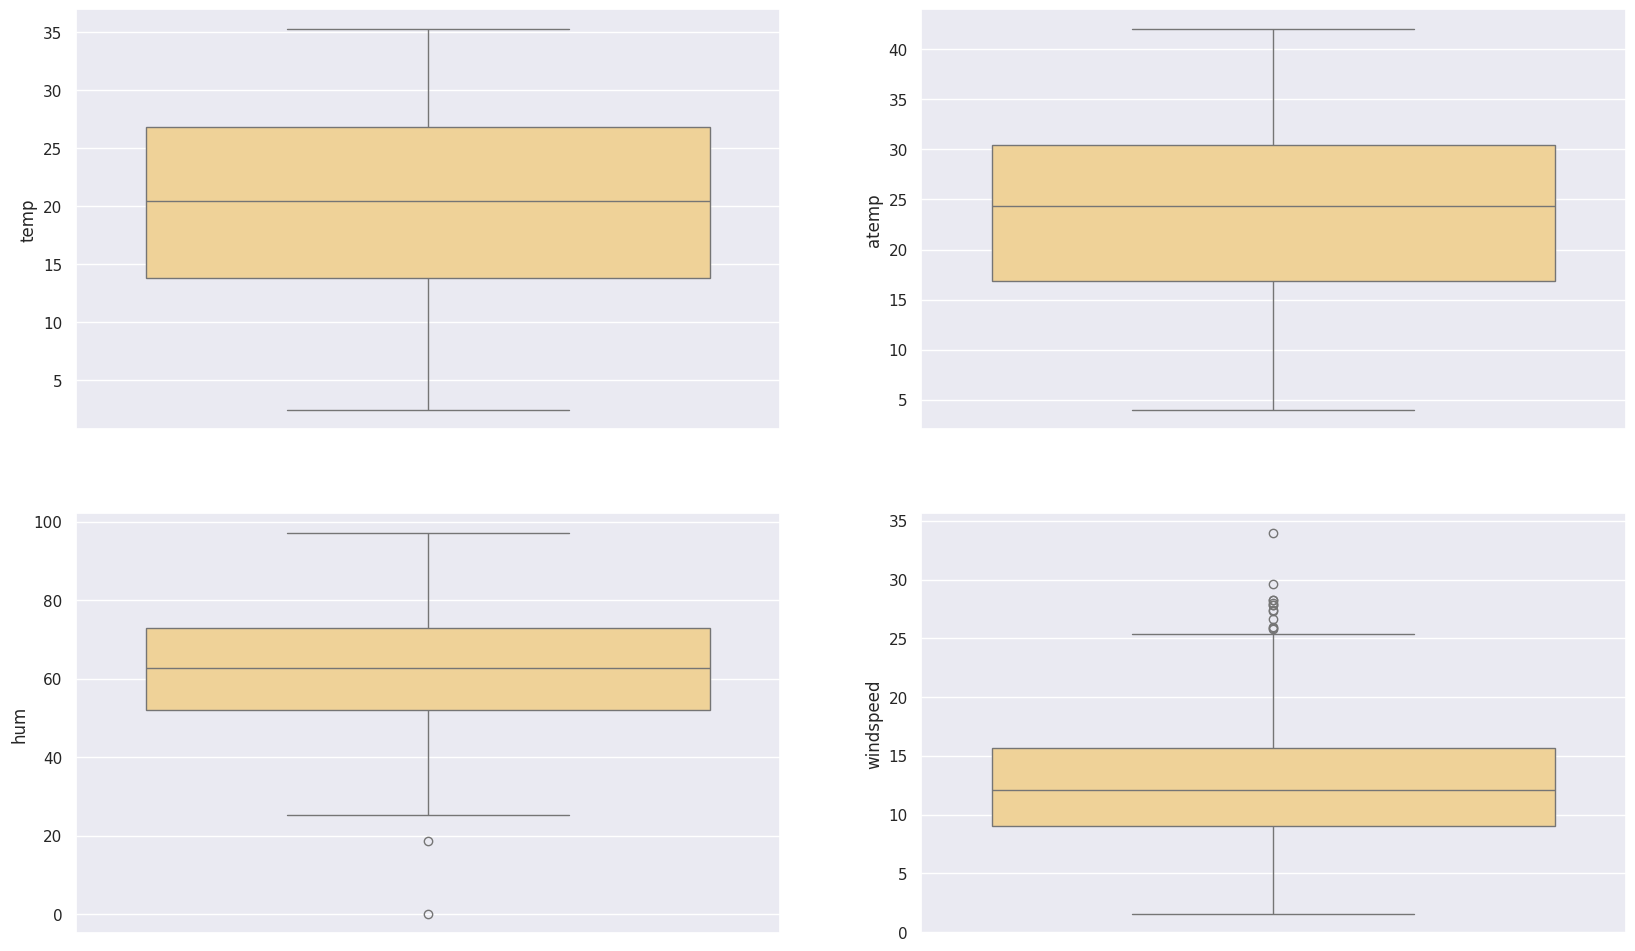

In [67]:
# checking for outliers in the numerical columns.
sns.set_theme(style="darkgrid")
palette = get_hex("Acadia", keep_first_n=2)

plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.boxplot(data=df[cont_cols[0]],palette=palette)

plt.subplot(2,2,2)
sns.boxplot(data=df[cont_cols[1]],palette=palette)

plt.subplot(2,2,3)
sns.boxplot(data=df[cont_cols[2]],palette=palette)

plt.subplot(2,2,4)
sns.boxplot(data=df[cont_cols[3]],palette=palette)

plt.savefig(os.path.join(image_dir,"outlier_detection.jpg"))

plt.show()



##### General observations:

* Temperature and apparent temperature have similar distributions, which is expected as they are related measures.
* Humidity has the widest range of values, covering the full 0-100 scale, suggesting it's measured as a percentage.
* Windspeed shows the most outliers, indicating occasional periods of much higher wind speeds than typical.
* The presence of outliers in humidity (low values) and windspeed (high values) could indicate unusual weather events or measurement errors that might warrant further investigation.

> Note: as there is not much deviation than the usual values we will be considering all the datapoints for model buildiding.



# Step3: Data Visualization and Analysis<a class="anchor" id="data_analysis"></a>


#### Univariate Analysis<a class="anchor" id="univarient_analysis"></a>

The primary goal is to understand the distribution, central tendency, and spread of the data for that variable

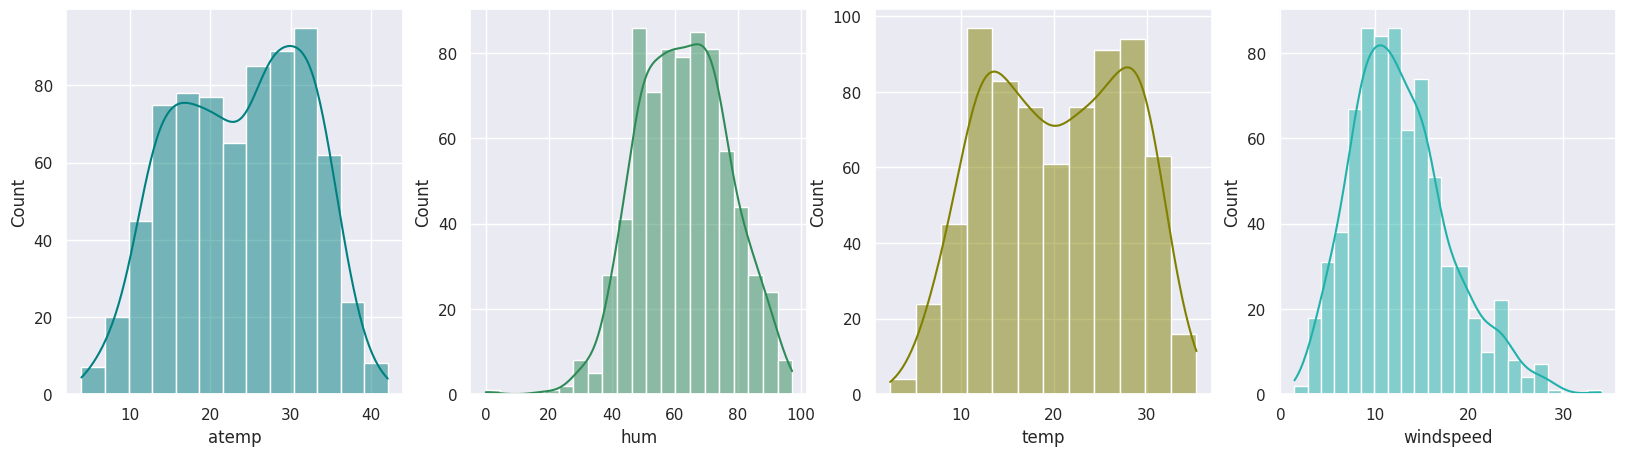

In [69]:
continuous_config = {
    'atemp': { 'color': 'teal' },
    'hum': { 'color': 'seagreen' },
    'temp': { 'color': 'olive' },
    'windspeed': { 'color': 'lightseagreen' }
}

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

for i, (cont, config) in enumerate(continuous_config.items()):
    sns.histplot(data = df, x = cont, ax = ax[i], color = config['color'], kde = True)


plt.savefig(os.path.join(image_dir,"distibution_plot_numerical.jpg"))
plt.show()


* Bikes were rented at an average temperature (temp) of 20°C.
* The average feeling temperature (atemp) during bike rentals is approximately 24°C.
* Humidity (hum) averaged around 62 during bike rentals.
* The average windspeed (windspeed) during bike rentals is approximately 12.


#### Bivariate Analysis <a class="anchor" id="bivariate"></a>

This involves examining the relationship between two variables to uncover any patterns or associations

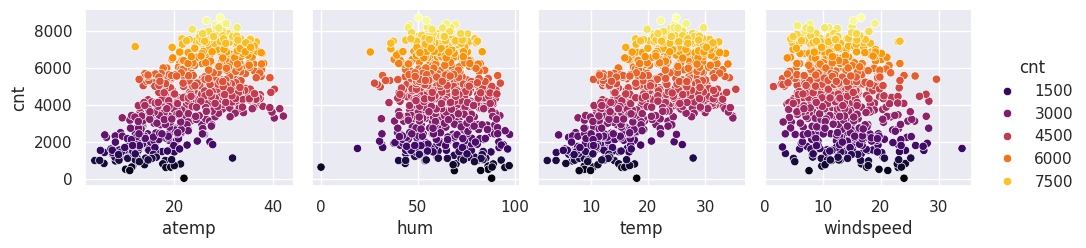

In [79]:
# Draw pairplot for continuous independent numeric variables against a dependent variable `cnt`
sns.pairplot(data = df, x_vars = list(continuous_config.keys()), y_vars = ['cnt'], hue = 'cnt', palette = 'inferno')
plt.savefig(os.path.join(image_dir,"bivariate_numerical.jpg"))
plt.show()


#### Key observations:
1. Count (cnt) vs Apparent Temperature (atemp):
   - There's a positive correlation between count and apparent temperature.
   - As atemp increases from 20 to 40, the count tends to increase from around 1000 to 8000.
   - The relationship appears somewhat non-linear, with a steeper increase in lower temperatures.

2. Count (cnt) vs Humidity (hum):
   - There's a weak negative correlation between count and humidity.
   - As humidity increases from 0 to 100, there's a slight overall decrease in count.
   - The relationship is not very strong, with a wide spread of count values across humidity levels.

3. Count (cnt) vs Temperature (temp):
   - Similar to atemp, there's a positive correlation between count and temperature.
   - The pattern closely resembles the atemp plot, which is expected given the close relationship between temperature and apparent temperature.
   - Count increases as temperature rises from 10 to 30.

4. Count (cnt) vs Wind Speed:
   - There's a weak negative correlation between count and wind speed.
   - As wind speed increases from 0 to 30, there's a slight decrease in count.
   - The relationship is not strong, with high variability in count across wind speeds.

This analysis suggests that warmer temperatures are associated with higher counts, while higher humidity and wind speed are associated with slightly lower counts.

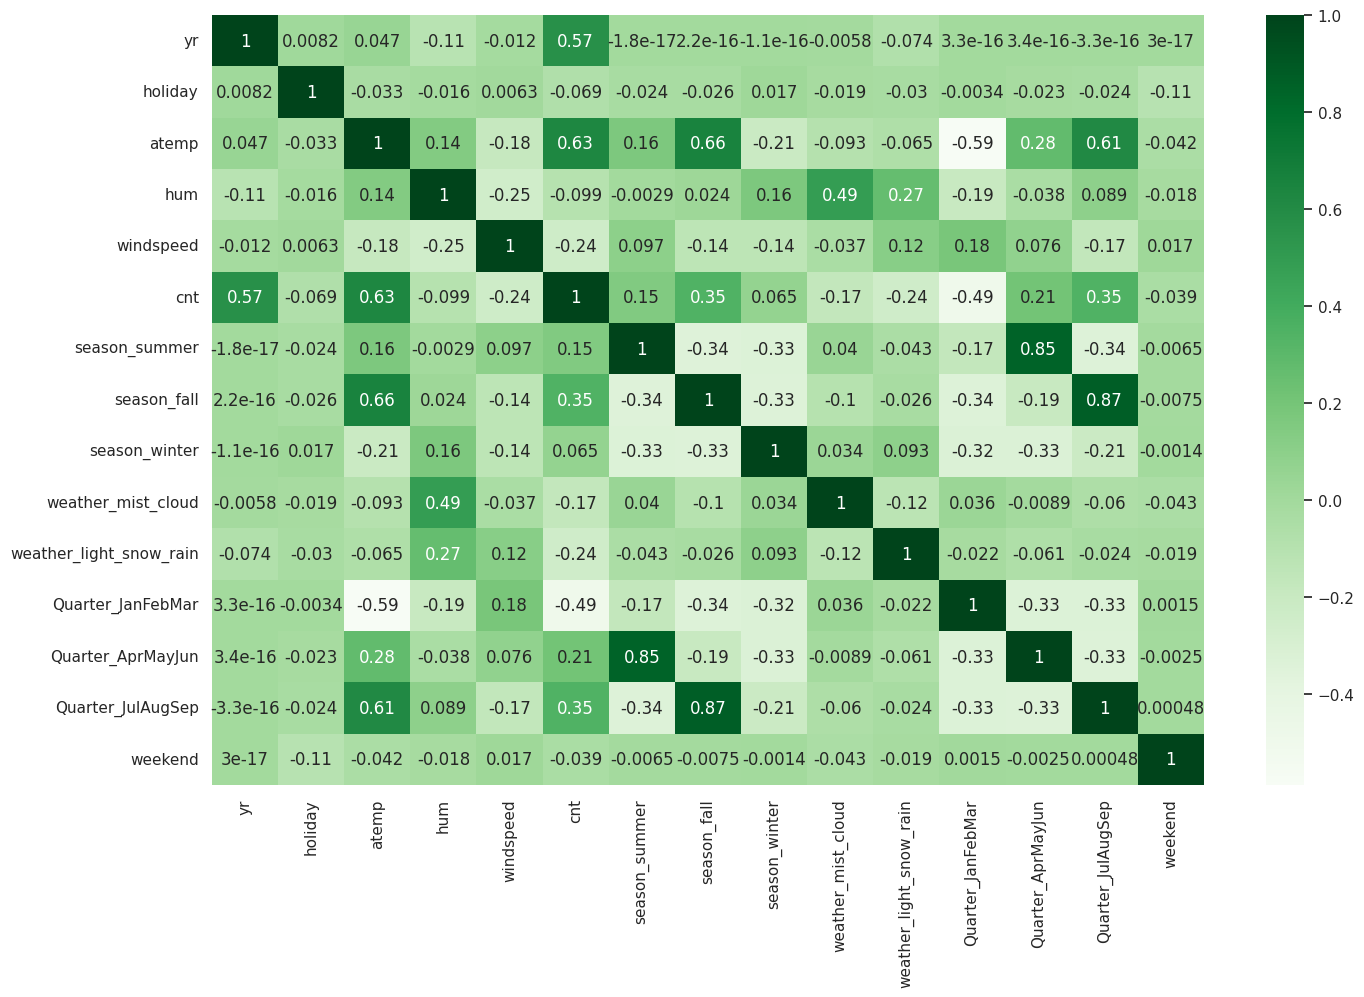

In [85]:
#Plotting correlation heatmap to analyze the linearity between the variables in the dataframe 
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="Greens")
plt.show()


#### Key observations:
1. Dropping column temp since it is very highly collinear with the column atemp.
2. Further,the column atemp is more appropriate for modelling compared to column temp from human perspective.



In [81]:
df.drop(columns=["temp"],axis=1,inplace =True)
df.head()


,yr,holiday,atemp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weather_mist_cloud,weather_light_snow_rain,Quarter_JanFebMar,Quarter_AprMayJun,Quarter_JulAugSep,weekend
0,0,0,18.18125,80.5833,10.749882,985,0,0,0,1,0,1,0,0,1
1,0,0,17.68695,69.6087,16.652113,801,0,0,0,1,0,1,0,0,1
2,0,0,9.47025,43.7273,16.636703,1349,0,0,0,0,0,1,0,0,0
3,0,0,10.60610,59.0435,10.739832,1562,0,0,0,0,0,1,0,0,0
4,0,0,11.46350,43.6957,12.522300,1600,0,0,0,0,0,1,0,0,0


# Step 4: Model Development<a class="anchor" id="model_devlopment"></a>

#### Train-Test Split<a class="anchor" id="data_splitting"></a>
Split the dataset into training and testing subsets, typically using 70-30 split. This ensures that the model is evaluated on unseen data for generalization.